# **Data Prep**

In [1]:
# Import libraries here
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.metrics import MeanAbsolutePercentageError


/Users/payalpatel/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# load the dataset
df = pd.read_csv('/Users/payalpatel/Downloads/HomeC2.csv', low_memory=False)

In [3]:
# check time rows to see the data
print(df['time'].head(10))

0    1451624400
1    1451624401
2    1451624402
3    1451624403
4    1451624404
5    1451624405
6    1451624406
7    1451624407
8    1451624408
9    1451624409
Name: time, dtype: object


In [4]:
# check for invalid rows in time (such as //)
rows = df[pd.to_numeric(df['time'], errors='coerce').isna()]

# remove invalid, keeping only numeric values
df = df[pd.to_numeric(df['time'], errors='coerce').notna()] 

# convert to datetime
df['time'] = pd.to_datetime(df['time'], unit='s')


/var/folders/84/ht7_l1r978j3q_sb0skfl4l80000gn/T/ipykernel_1379/190397704.py:8: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['time'] = pd.to_datetime(df['time'], unit='s')


In [5]:
# create variables for weather and energy consumption
weather_variables = ['temperature', 'humidity', 'apparentTemperature', 'windSpeed', 'windBearing','dewPoint']
target_variable = 'House overall [kW]'

dataset = df[[target_variable] + weather_variables].copy()

# add rolling and lagged features for dependencies and trends
dataset['mean_roll'] = dataset[target_variable].rolling(window=7).mean()
dataset['std_roll'] = dataset[target_variable].rolling(window=7).std()

dataset['lag'] = dataset[target_variable].shift(1)
dataset['2lag'] = dataset[target_variable].shift(2)

# fill missing values, if any
data = dataset.bfill()

# scale target and weather variables separately for better model accuracy 
scaler = MinMaxScaler()
scaled_weather = scaler.fit_transform(data[weather_variables])
scaler_target = MinMaxScaler()
scaled_target = scaler_target.fit_transform(data[[target_variable]])

# create sequences of data for time series prediciton
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])  
        y.append(data[i+time_steps, 0])  
    return np.array(X), np.array(y)

# combine weather and energy consumption variables for sequence
combine_t_w = np.hstack([scaled_weather, scaled_target])

# predictions are for 7 days (24 (hours) * 7 (days)= 168)
time_steps = 168 

# create sequences
X, y = create_sequences(combine_t_w, time_steps)

# 80% training and 20% testing split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# y_test has one NaN, we can replace it with the mean value
y_test = np.nan_to_num(y_test, nan=np.nanmean(y_test)) 

X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)

# **LSTM Model**

In [6]:
# define the LSTM model - add input, output, dense, LSTM 
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=100, return_sequences=True))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25, activation='relu'))
model.add(Dense(units=1, activation='linear'))

# use adam optimization
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', MeanAbsolutePercentageError()])

# **Train the Model**

In [7]:
# early stop (7 epochs before stopping)
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train LSTM
history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stop])

Epoch 1/100
3149/3149 ━━━━━━━━━━━━━━━━━━━━ 926s 294ms/step - loss: 0.0020 - mae: 0.0126 - mean_absolute_percentage_error: 9358.1367 - val_loss: 2.3215e-05 - val_mae: 0.0030 - val_mean_absolute_percentage_error: 0.6547
Epoch 2/100
3149/3149 ━━━━━━━━━━━━━━━━━━━━ 2674s 849ms/step - loss: 3.1532e-05 - mae: 0.0036 - mean_absolute_percentage_error: 391.1278 - val_loss: 2.4514e-05 - val_mae: 0.0039 - val_mean_absolute_percentage_error: 0.8306
Epoch 3/100
3149/3149 ━━━━━━━━━━━━━━━━━━━━ 776s 247ms/step - loss: 2.3207e-05 - mae: 0.0032 - mean_absolute_percentage_error: 310.8444 - val_loss: 1.4523e-05 - val_mae: 0.0027 - val_mean_absolute_percentage_error: 0.6130
Epoch 4/100
3149/3149 ━━━━━━━━━━━━━━━━━━━━ 1157s 367ms/step - loss: 1.7345e-05 - mae: 0.0026 - mean_absolute_percentage_error: 241.3839 - val_loss: 8.7697e-06 - val_mae: 0.0017 - val_mean_absolute_percentage_error: 0.3796
Epoch 5/100
3149/3149 ━━━━━━━━━━━━━━━━━━━━ 744s 236ms/step - loss: 1.4086e-05 - mae: 0.0023 - mean_absolute_percentag

# **Evaluate the Model**

In [8]:
# evaluate LSTM model using mae (but subtract by 100)
loss, mae, mape = model.evaluate(X_test, y_test, verbose=0)
accuracy = 100 - mape
print(f"Accuracy: {accuracy:2f}%")

Accuracy: 99.842634%


# **Future Energy Consumption**

/var/folders/84/ht7_l1r978j3q_sb0skfl4l80000gn/T/ipykernel_1379/3978697778.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_point[0, -1, -1] = next


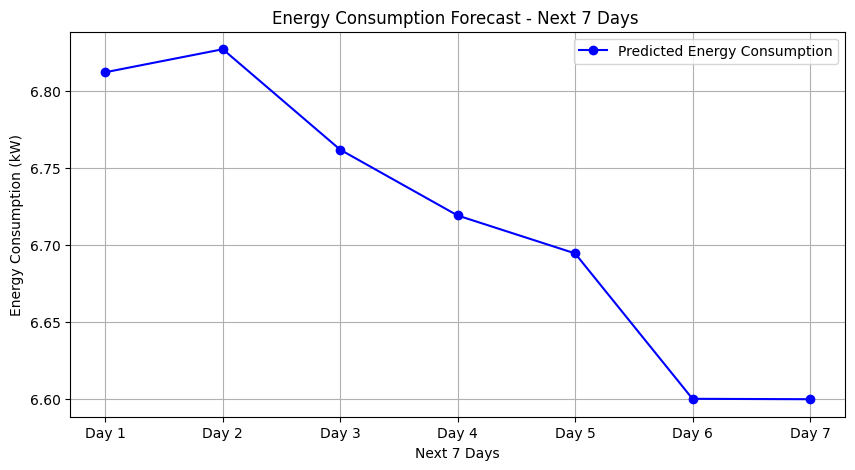

In [9]:
# same as time_steps 168 hours of predictions
predictions = 7 * 24

# use the last datapoint to start future predictions
last_point = X_test[-1].reshape(1, time_steps, X_test.shape[2])

# store the prediction 
future_prediction = []

# generate the next prediction
for _ in range(predictions):
    next = model.predict(last_point, verbose=0)  
    future_prediction.append(next[0, 0])  

    # update the last point and add next prediction
    last_point = np.roll(last_point, shift=-1, axis=1)
    last_point[0, -1, -1] = next  

# make sure predictions are back to the orignal scale (use reshape)
original_pred = scaler_target.inverse_transform(np.array(future_prediction).reshape(-1, 1))

# aggregate predictions into daily average
daily_avg = np.mean(original_pred.reshape(7, 24), axis=1)

# since we are plots 7 days, create labels for each of the 7 days
label_day = [f"Day {i+1}" for i in range(7)]

# plot predictions for 7 days (add points for each day)
plt.figure(figsize=(10, 5))
plt.plot(label_day, daily_avg, marker='o', color='blue', label='Predicted Energy Consumption')
plt.xlabel('Next 7 Days')
plt.ylabel('Energy Consumption (kW)')
plt.title('Energy Consumption Forecast - Next 7 Days ')
plt.legend()
plt.grid()
plt.show()

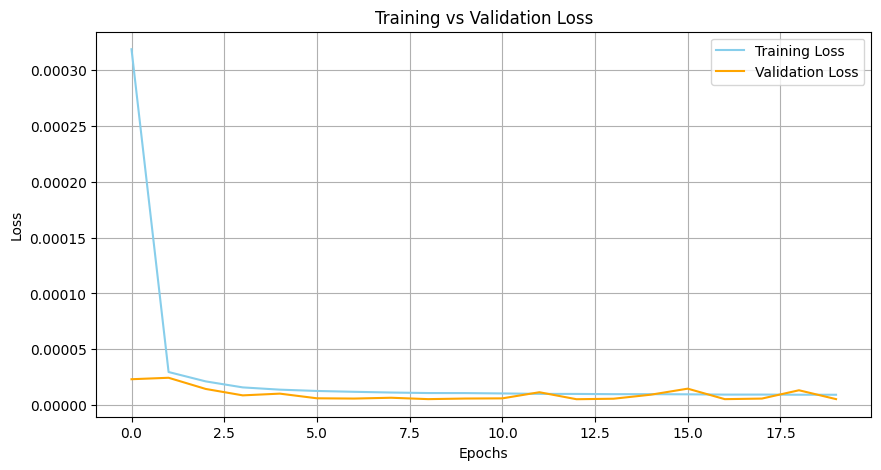

In [10]:
# plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='skyblue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()


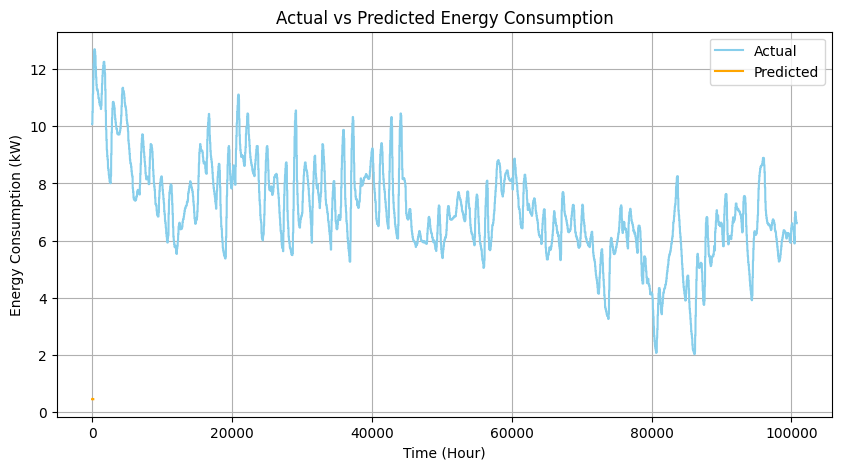

In [11]:
# convert actual test values back to original scale
y_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# plot actual and predicted 
plt.figure(figsize=(10, 5))
plt.plot(y_rescaled, label='Actual', color='skyblue')
plt.plot(future_prediction, label='Predicted', color='orange')
plt.xlabel('Time (Hour)')
plt.ylabel('Energy Consumption (kW)')
plt.title('Actual vs Predicted Energy Consumption')
plt.legend()
plt.grid()
plt.show()

In [16]:
y_rescaled = y_rescaled.ravel()  # Flatten the array
y_rescaled = y_rescaled[:7]  # Take only the first 7 values (if correct)

In [17]:
# dataframe for actual and predicted daily values
data = {
    'Day': label_day,
    'Actual Energy Consumption (kW)': y_rescaled,
    'Predicted Energy Consumption (kW)': daily_avg
}
df = pd.DataFrame(data)

# save csv file
df.to_csv('/Users/payalpatel/Downloads/energy_consumption_forecast.csv', index=False)

print("Saved")

Saved
